# Measure a Profile

## Note

All functions in this section can be used passing the explicit arguments but are also internal functions of the cluster object, and should be used as such. They are just explicitely used here for clarity.

Ex:

```
theta, g_t, g_x = compute_tangential_and_cross_components(ra_lens, dec_lens,
                ra_source, dec_source, shear1, shear2, geometry="flat")
```

should be done by the user as:

```
theta, g_t, g_x = cl.compute_tangential_and_cross_components(geometry="flat")
```

In [1]:
import matplotlib.pyplot as plt
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock

import warnings
warnings.filterwarnings('ignore')

Make sure we know which version we're using

In [2]:
clmm.__version__

'1.0.0'

### Define cosmology object

In [3]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

## 1. Generate cluster object from mock data
In this example, the mock data includes: shape noise, galaxies drawn from redshift distribution and photoz errors.

Define toy cluster parameters for mock data generation

In [4]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 1000

zsrc_min = cluster_z + 0.1 # we only want to draw background galaxies

noisy_data_z = mock.generate_galaxy_catalog(cluster_m,
                                            cluster_z,
                                            concentration,
                                            cosmo,
                                            'chang13',
                                            zsrc_min=zsrc_min,
                                            shapenoise=0.005,
                                            photoz_sigma_unscaled=0.05, ngals=ngals)

Loading this into a CLMM cluster object centered on (0,0)

In [5]:
cluster_ra = 0.0
cluster_dec = 0.0
cl = GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                               cluster_z, noisy_data_z)

### 2. Load cluster object containing:
> Lens properties (ra_l, dec_l, z_l)

> Source properties (ra_s, dec_s, e1, e2)
### Note, if loading from mock data, use: 
> cl = gc.GalaxyCluster.load("GC_from_mock_data.pkl")

In [6]:
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra,
      "; dec:", cl.dec, "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

Cluster info = ID: Awesome_cluster ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 1000


## 2. Basic checks and plots 
- galaxy positions
- redshift distribution

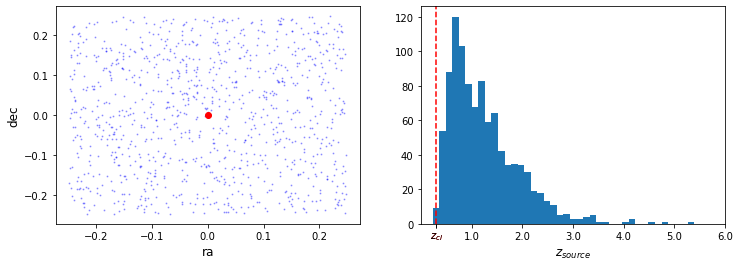

In [7]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(cl.galcat['ra'], cl.galcat['dec'], color='blue', s=1, alpha=0.3)
ax[0].plot(cl.ra, cl.dec, 'ro')
ax[0].set_ylabel('dec', fontsize="large")
ax[0].set_xlabel('ra', fontsize="large")

hist = ax[1].hist(cl.galcat['z'], bins=40)[0]
ax[1].axvline(cl.z, c='r', ls='--')
ax[1].set_xlabel('$z_{source}$', fontsize="large")
xt = {t:f'{t}' for t in ax[1].get_xticks() if t!=0}
xt[cl.z] ='$z_{cl}$'
xto = sorted(list(xt.keys())+[cl.z])
ax[1].set_xticks(xto)
ax[1].set_xticklabels(xt[t] for t in xto)
ax[1].get_xticklabels()[xto.index(cl.z)].set_color('red')
plt.xlim(0, max(xto))
plt.show()

- Check ellipticities

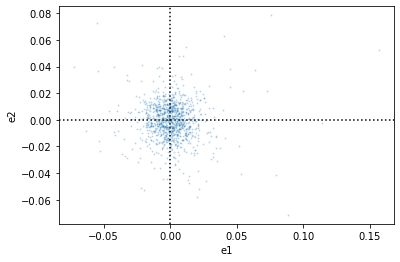

In [8]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(cl.galcat['e1'], cl.galcat['e2'], s=1, alpha=0.2)
ax1.set_xlabel('e1')
ax1.set_ylabel('e2')
ax1.set_aspect('equal', 'datalim')
ax1.axvline(0, linestyle='dotted', color='black')
ax1.axhline(0, linestyle='dotted', color='black')

## 3. Compute and plot shear profiles

### 3.1 Compute angular separation, cross and tangential shear for each source galaxy

In [9]:
theta, e_t, e_x = compute_tangential_and_cross_components(
                ra_lens=cl.ra, dec_lens=cl.dec,
                ra_source=cl.galcat['ra'], dec_source=cl.galcat['dec'],
                shear1=cl.galcat['e1'], shear2=cl.galcat['e2'],
                geometry="flat")

#### 3.1.1 Using `GalaxyCluster` object
- You can also call the function directly from the `GalaxyCluster` object
- By defaut, `compute_tangential_and_cross_components` uses columns named `e1` and `e2` of the `galcat` table

In [10]:
cl.compute_tangential_and_cross_components(geometry="flat", add=True)
# With the option add the cl object has theta, et and ex new columns 
# (default: takes in columns named 'e1' and 'e2' and save the results in 'et' and 'ex')
cl.galcat['et', 'ex'].pprint(max_width=-1)

          et                    ex          
--------------------- ----------------------
 0.014268440150663518  -0.004954341787933816
  0.03286517847161026 -0.0030799490630489326
 0.012731288557196619  0.0020016892607194396
 0.004108584553347905  0.0054255279827542455
 0.011508929207783397  0.0008943661413648588
 0.042294806668346493 -0.0030088524406152416
0.0013818305567597725  0.0022256606408801276
 0.007958325024529422  0.0032015595420701523
5.009122229024908e-05  -0.008431557560564152
 0.015469806062697291  -0.006067878075804936
                  ...                    ...
-0.004137287915695721   0.004019277497586831
 0.011793675616981612 -0.0022429331585242696
 0.009288121306593676 -0.0015919254772567295
  0.01277991390700912 -0.0007027683316552765
 0.015139212734867328  -0.004941472552824152
  0.01482290812242831   0.005853951523309806
  0.01607247667948097   0.003375271619801592
 0.000583998652177691  0.0013481061090122011
 0.008137358979514718  -0.004030537881188273
 0.0093139

- But it's also possible to choose which columns to use for input and output, e.g. Below we're storing the results in `e_tan` and `e_cross` instead (explicitely taking `e1` and `e2` as input)


In [11]:
cl.compute_tangential_and_cross_components(geometry="flat",
                                                      shape_component1='e1', shape_component2='e2', 
                                                      tan_component='e_tan', cross_component='e_cross',
                                                      add=True)
cl.galcat['e_tan', 'e_cross'].pprint(max_width=-1)

        e_tan                e_cross        
--------------------- ----------------------
 0.014268440150663518  -0.004954341787933816
  0.03286517847161026 -0.0030799490630489326
 0.012731288557196619  0.0020016892607194396
 0.004108584553347905  0.0054255279827542455
 0.011508929207783397  0.0008943661413648588
 0.042294806668346493 -0.0030088524406152416
0.0013818305567597725  0.0022256606408801276
 0.007958325024529422  0.0032015595420701523
5.009122229024908e-05  -0.008431557560564152
 0.015469806062697291  -0.006067878075804936
                  ...                    ...
-0.004137287915695721   0.004019277497586831
 0.011793675616981612 -0.0022429331585242696
 0.009288121306593676 -0.0015919254772567295
  0.01277991390700912 -0.0007027683316552765
 0.015139212734867328  -0.004941472552824152
  0.01482290812242831   0.005853951523309806
  0.01607247667948097   0.003375271619801592
 0.000583998652177691  0.0013481061090122011
 0.008137358979514718  -0.004030537881188273
 0.0093139

Plot tangential and cross ellipticity distributions for verification, which can be accessed in the galaxy cluster object, cl.

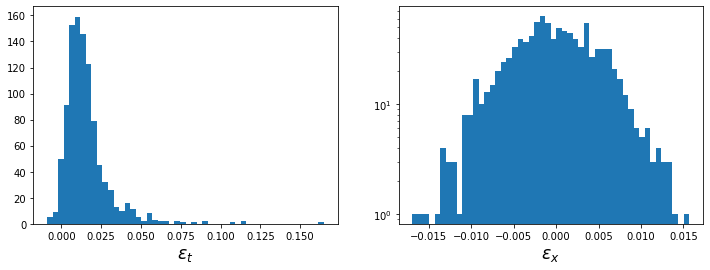

In [12]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].hist(cl.galcat['et'],bins=50)
ax[0].set_xlabel('$\\epsilon_t$',fontsize='xx-large')

ax[1].hist(cl.galcat['ex'],bins=50)
ax[1].set_xlabel('$\\epsilon_x$',fontsize='xx-large')
ax[1].set_yscale('log')

Compute transversal and cross shear profiles in units defined by user, using defaults binning 

### 3.2 Compute shear profile in radial bins
Given the separations in "radians" computed in the previous step, the user may ask for a binned profile in various projected distance units.
#### 3.2.1 Default binning
- default binning using kpc:

In [13]:
profiles = make_radial_profile([cl.galcat['et'], cl.galcat['ex'], cl.galcat['z']],
                                    angsep=cl.galcat['theta'], angsep_units="radians",
                                    bin_units="kpc", cosmo=cosmo, z_lens=cl.z)
profiles.pprint(max_width=-1)
#profiles.show_in_notebook()

    radius_min           radius           radius_max              p_0                 p_0_err                   p_1                  p_1_err                p_2               p_2_err        n_src
------------------ ------------------ ------------------ --------------------- ---------------------- ----------------------- ---------------------- ------------------ -------------------- -----
 94.60205694146863 412.41685982248487  645.6757545692755   0.07734304176489455   0.007462843759771058  -0.0013143819336840718   0.001083800252721594 1.5147352500491638   0.2569786499938531    18
 645.6757545692755  939.7320876366845 1196.7494521970823   0.04105607921426797  0.0015577531247907782  -0.0004777384828311897  0.0005931849773769037 1.1210531393890673   0.0664755735154625    57
1196.7494521970823 1476.0520014948906 1747.8231498248892  0.026586209236259838  0.0010524350151957533   0.0001162439094273901  0.0005536642723937506 1.2309201323098462  0.07503593541492085    78
1747.8231498248892 2030.2

Note that, because this function bins a generic number of quantities in the radial profile, its output table names the quantities as `p_i` and errors as `p_i_err`.

#### 3.1.2 Using `GalaxyCluster` object
The output `GCData` corresponding to the binning profiled is attached as a new attribute of the galaxy cluster object.

In [14]:
cl.make_radial_profile("kpc", cosmo=cosmo)
cl.profile.pprint(max_width=-1)
#cl.profile.show_in_notebook()

    radius_min           radius           radius_max               gt                  gt_err                    gx                   gx_err                 z                 z_err         n_src
------------------ ------------------ ------------------ --------------------- ---------------------- ----------------------- ---------------------- ------------------ -------------------- -----
 94.60205694146863 412.41685982248487  645.6757545692755   0.07734304176489455   0.007462843759771058  -0.0013143819336840718   0.001083800252721594 1.5147352500491638   0.2569786499938531    18
 645.6757545692755  939.7320876366845 1196.7494521970823   0.04105607921426797  0.0015577531247907782  -0.0004777384828311897  0.0005931849773769037 1.1210531393890673   0.0664755735154625    57
1196.7494521970823 1476.0520014948906 1747.8231498248892  0.026586209236259838  0.0010524350151957533   0.0001162439094273901  0.0005536642723937506 1.2309201323098462  0.07503593541492085    78
1747.8231498248892 2030.2

You can see that this `profile` table contains metadata regarding the comology and bin units

In [15]:
print('Cosmology:', cl.profile.meta['cosmo'])
print('bin units:', cl.profile.meta['bin_units'])

Cosmology: CCLCosmology(H0=70.0, Omega_dm0=0.22500000000000003, Omega_b0=0.045, Omega_k0=0.0)
bin units: kpc


Use function to plot the profiles

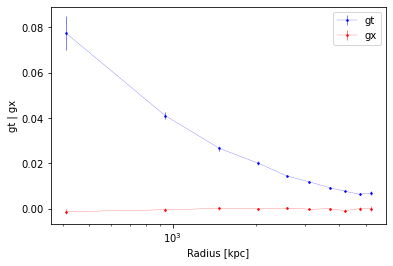

In [16]:
fig, ax = cl.plot_profiles(xscale='log')

- default binning using degrees:

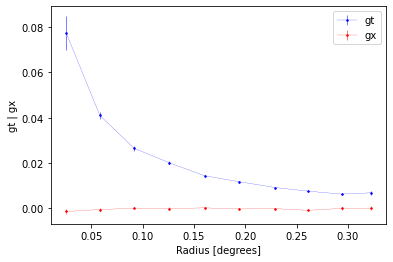

In [17]:
new_profiles = cl.make_radial_profile("degrees",cosmo=cosmo)
fig1, ax1 = cl.plot_profiles()

#### 3.2.2 User-defined binning 
The users may also provide their own binning, in user-defined units, to compute the transversal and cross shear profiles. The `make_bins` function is provided in `utils.py` and allow for various options. 

- e.g., generate 20 bins between 1 and 6 Mpc, linearly spaced.

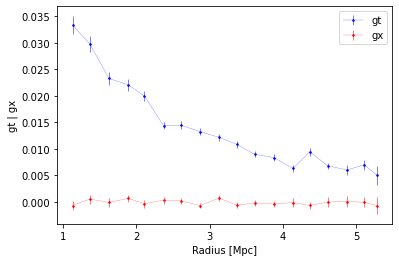

In [18]:
new_bins = make_bins(1, 6, nbins=20, method='evenwidth')

# Make the shear profile in this binning
new_profiles = cl.make_radial_profile("Mpc",
                                  bins=new_bins, cosmo=cosmo)

fig1, ax1 = cl.plot_profiles()

- e.g., generate 20 bins between 1 and 6 Mpc, evenly spaced in log space.

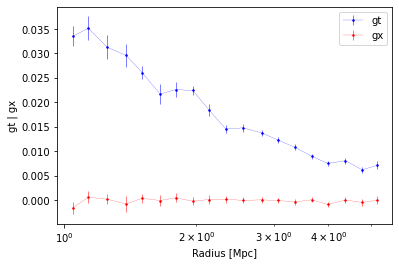

In [19]:
new_bins = make_bins(1, 6, nbins=20, method='evenlog10width')

new_profiles = cl.make_radial_profile("Mpc",
                                  bins=new_bins, cosmo=cosmo)
fig1, ax1 = cl.plot_profiles()
ax1.set_xscale('log')

- e.g., generate 20 bins between 1 and 6 Mpc, each contaning the same number of galaxies

number of galaxies in each bin: [48, 47, 48, 47, 47, 48, 47, 47, 48, 47, 47, 48, 47, 47, 48, 47, 47, 48, 47, 48]


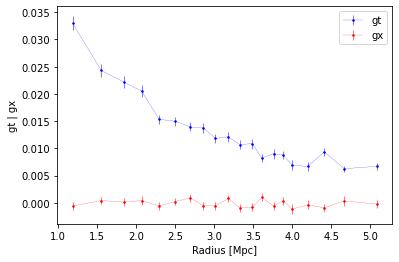

In [20]:
# First, convert the source separation table to Mpc
seps = u.convert_units(cl.galcat["theta"], "radians", "Mpc", redshift=cl.z, cosmo=cosmo)

new_bins = make_bins(1, 6, nbins=20, method='equaloccupation', source_seps=seps)
new_profiles = cl.make_radial_profile("Mpc",bins=new_bins, cosmo=cosmo)

print(f"number of galaxies in each bin: {list(cl.profile['n_src'])}")
fig1, ax1 = cl.plot_profiles()

#### 3.2.3 Other individual profile quantities may also be accessed 

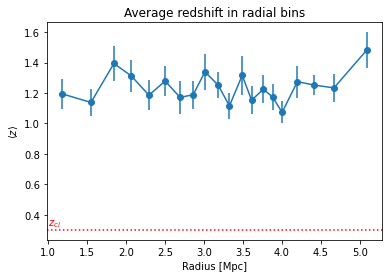

In [21]:
plt.title('Average redshift in radial bins')
plt.errorbar(new_profiles['radius'], new_profiles['z'],
             new_profiles['z_err'], marker = 'o')
plt.axhline(cl.z, linestyle='dotted', color='r')
plt.text(1, cl.z*1.1, '$z_{cl}$', color='r')
plt.xlabel("Radius [Mpc]")
plt.ylabel('$\langle z\\rangle$')
plt.show()

## 4. Focus on some options
### 4.1. `gal_ids_in_bins` option 
adds a `gal_id` field to the profile GCData. For each bin of the profile, this is filled with the list of galaxy IDs for the galaxies that have fallen in that bin.

In [22]:
cl.make_radial_profile("Mpc", cosmo=cosmo, gal_ids_in_bins=True)
cl.profile[:2].pprint(max_width=-1)
#cl.profile[:2].show_in_notebook()

     radius_min           radius           radius_max              gt                 gt_err                  gx                   gx_err                z                z_err        n_src                                                                                                                                        gal_id                                                                                                                                      
------------------- ------------------ ------------------ ------------------- --------------------- ---------------------- --------------------- ------------------ ------------------ ----- -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0.09460205694146863 0.4124168598224849 0.6456757545692755 0.0773430417

In [23]:
# Here the list of galaxy IDs that are in the first bin of the tangential shear profile
import numpy as np
gal_list = cl.profile['gal_id'][0]
print(gal_list)

[82, 118, 119, 155, 189, 325, 430, 437, 451, 651, 763, 810, 824, 866, 930, 954, 959, 982]


### 4.2. User-defined naming scheme
The user may specify which columns to use from the `galcat` table to perform the binned average. If none is specified, the code looks for columns names `et` and `ex`. Below, we average in bins the columns`e_tan` and `e_cross` of `galcat` and store the results in the columns `g_tan` and `g_cross` of the `profile` table of the cluster object.

In [24]:
cl.make_radial_profile("kpc", cosmo=cosmo, 
                       tan_component_in='e_tan', cross_component_in='e_cross',
                       tan_component_out='g_tan', cross_component_out='g_cross');
cl.profile.pprint(max_width=-1)
#cl.profile.show_in_notebook()

    radius_min           radius           radius_max             g_tan               g_tan_err                g_cross              g_cross_err               z                 z_err         n_src
------------------ ------------------ ------------------ --------------------- ---------------------- ----------------------- ---------------------- ------------------ -------------------- -----
 94.60205694146863 412.41685982248487  645.6757545692755   0.07734304176489455   0.007462843759771058  -0.0013143819336840718   0.001083800252721594 1.5147352500491638   0.2569786499938531    18
 645.6757545692755  939.7320876366845 1196.7494521970823   0.04105607921426797  0.0015577531247907782  -0.0004777384828311897  0.0005931849773769037 1.1210531393890673   0.0664755735154625    57
1196.7494521970823 1476.0520014948906 1747.8231498248892  0.026586209236259838  0.0010524350151957533   0.0001162439094273901  0.0005536642723937506 1.2309201323098462  0.07503593541492085    78
1747.8231498248892 2030.2

The user may also define the name of the output table attribute. Below, we asked the binned profile to be saved into the `reduced_shear_profile` attribute

In [25]:
cl.make_radial_profile("kpc", cosmo=cosmo, 
                       tan_component_in='e_tan', cross_component_in='e_cross',
                       tan_component_out='g_tan', cross_component_out='g_cross',
                       table_name='reduced_shear_profile');
cl.reduced_shear_profile.pprint(max_width=-1)
#cl.reduced_shear_profile.show_in_notebook()

    radius_min           radius           radius_max             g_tan               g_tan_err                g_cross              g_cross_err               z                 z_err         n_src
------------------ ------------------ ------------------ --------------------- ---------------------- ----------------------- ---------------------- ------------------ -------------------- -----
 94.60205694146863 412.41685982248487  645.6757545692755   0.07734304176489455   0.007462843759771058  -0.0013143819336840718   0.001083800252721594 1.5147352500491638   0.2569786499938531    18
 645.6757545692755  939.7320876366845 1196.7494521970823   0.04105607921426797  0.0015577531247907782  -0.0004777384828311897  0.0005931849773769037 1.1210531393890673   0.0664755735154625    57
1196.7494521970823 1476.0520014948906 1747.8231498248892  0.026586209236259838  0.0010524350151957533   0.0001162439094273901  0.0005536642723937506 1.2309201323098462  0.07503593541492085    78
1747.8231498248892 2030.2

### 4.3 Compute a DeltaSigma profile instead of a shear profile

The `is_deltasigma` option allows the user to return a cross and tangential $\Delta\Sigma$ (excess surface density) value for each galaxy in the catalog, provided `galcat` contains the redshifts of the galaxies and provided a cosmology is passed to the function. The columns `DeltaSigma_tan` and `DeltaSigma_cross` are added to the `galcat` table.

In [ ]:
cl.compute_tangential_and_cross_components(geometry="flat",
                                                      shape_component1='e1', shape_component2='e2', 
                                                      tan_component='DeltaSigma_tan', cross_component='DeltaSigma_cross',
                                                      add=True, cosmo=cosmo, is_deltasigma=True)
cl

Because this operation required a Cosmology, it was added to `galcat` metadata:

In [27]:
cl.galcat.meta['cosmo']

'CCLCosmology(H0=70.0, Omega_dm0=0.22500000000000003, Omega_b0=0.045, Omega_k0=0.0)'

The binned profile is obtained, as before. Below, we use the values obtained from the previous step to compute the binned profile. The latter is saved in a new `DeltaSigma_profile` table of the GalaxyCluster object.

In [28]:
cl.make_radial_profile("Mpc", cosmo=cosmo, 
                       tan_component_in='DeltaSigma_tan', cross_component_in='DeltaSigma_cross',
                       tan_component_out='DeltaSigma_tan', cross_component_out='DeltaSigma_cross',
                       table_name='DeltaSigma_profile').pprint(max_width=-1)
'''
cl.make_radial_profile("Mpc", cosmo=cosmo, 
                       tan_component_in='DeltaSigma_tan', cross_component_in='DeltaSigma_cross',
                       tan_component_out='DeltaSigma_tan', cross_component_out='DeltaSigma_cross',
                       table_name='DeltaSigma_profile').show_in_notebook()
'''

     radius_min           radius           radius_max       DeltaSigma_tan   DeltaSigma_tan_err   DeltaSigma_cross  DeltaSigma_cross_err         z                 z_err         n_src
------------------- ------------------ ------------------ ------------------ ------------------ ------------------- -------------------- ------------------ -------------------- -----
0.09460205694146863 0.4124168598224849 0.6456757545692755 222021225782206.88  23525810334589.15  -6238978602215.721   4129355296427.8037 1.5147352500491638   0.2569786499938531    18
 0.6456757545692755 0.9397320876366841 1.1967494521970825 118254981441278.28  2555062307356.587   -837455039216.208    1769947019714.909 1.1210531393890673   0.0664755735154625    57
 1.1967494521970825 1.4760520014948906 1.7478231498248895  77394417659448.81  2354700113032.541  11054368708.245207    2615989716898.861 1.2309201323098462  0.07503593541492085    78
 1.7478231498248895 2.0302048774762436  2.298896847452696  56232765769281.67  1730698

'\ncl.make_radial_profile("Mpc", cosmo=cosmo, \n                       tan_component_in=\'DeltaSigma_tan\', cross_component_in=\'DeltaSigma_cross\',\n                       tan_component_out=\'DeltaSigma_tan\', cross_component_out=\'DeltaSigma_cross\',\n                       table_name=\'DeltaSigma_profile\').show_in_notebook()\n'

In [29]:
cl.DeltaSigma_profile.pprint(max_width=-1)
#cl.DeltaSigma_profile.show_in_notebook()

     radius_min           radius           radius_max       DeltaSigma_tan   DeltaSigma_tan_err   DeltaSigma_cross  DeltaSigma_cross_err         z                 z_err         n_src
------------------- ------------------ ------------------ ------------------ ------------------ ------------------- -------------------- ------------------ -------------------- -----
0.09460205694146863 0.4124168598224849 0.6456757545692755 222021225782206.88  23525810334589.15  -6238978602215.721   4129355296427.8037 1.5147352500491638   0.2569786499938531    18
 0.6456757545692755 0.9397320876366841 1.1967494521970825 118254981441278.28  2555062307356.587   -837455039216.208    1769947019714.909 1.1210531393890673   0.0664755735154625    57
 1.1967494521970825 1.4760520014948906 1.7478231498248895  77394417659448.81  2354700113032.541  11054368708.245207    2615989716898.861 1.2309201323098462  0.07503593541492085    78
 1.7478231498248895 2.0302048774762436  2.298896847452696  56232765769281.67  1730698

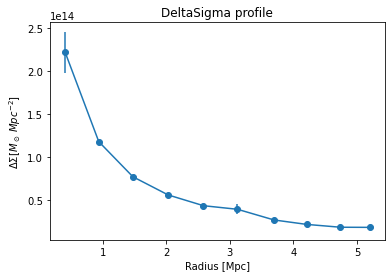

In [30]:
plt.errorbar(cl.DeltaSigma_profile['radius'], cl.DeltaSigma_profile['DeltaSigma_tan'],
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o')
plt.title('DeltaSigma profile')
plt.xlabel("Radius [Mpc]")
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.show()